### Questions

- What does label look like if no raccoons?
- How is loss calculated for bounding box?

### Thoughts

- if we resize, we have to rescale bounding box also

In [1]:
import cv2
import time
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as A
import albumentations
from albumentations.pytorch import ToTensorV2

In [2]:
data_path = './Data/Racoon Images/images'
df = pd.read_csv('./Data/train_labels_.csv')

In [3]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [168]:
# Sample Image
path = data_path + '/' + df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(194, 259, 3)

In [169]:
# Bounding box for sample image
x0 = df.iloc[0]['xmin']
y0 = df.iloc[0]['ymin']
x1 = df.iloc[0]['xmax']
y1 = df.iloc[0]['ymax']
(x0,y0), (x1,y1)

((95, 60), (167, 118))

In [170]:
def display_imgbb(img, xmin, ymin, xmax, ymax):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin), (xmax - xmin) , (ymax - ymin) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

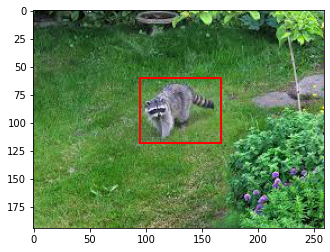

In [171]:
display_imgbb(img,x0,y0,x1,y1)

In [172]:
# smallest w,h
df['width'].min(), df['height'].min()

(178, 154)

In [4]:
# Rescale bounding box in preparation for rescaling images
image_size = 128
df['xmin_rs'] = df['xmin']*image_size/df['width']
df['xmax_rs'] = df['xmax']*image_size/df['width']
df['ymin_rs'] = df['ymin']*image_size/df['height']
df['ymax_rs'] = df['ymax']*image_size/df['height']

In [5]:
# Images with >1 raccoon, remove to simplify model
new = pd.DataFrame(df.filename.value_counts() > 1)
new = new.reset_index()
new = new[new['filename'] == True]
for_removal = list(new['index'].values)
len(for_removal)

12

In [6]:
# Images with 1 raccoon only
df = df[~df['filename'].isin(for_removal)]
len(df)

148

In [31]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,xmin_rs,xmax_rs,ymin_rs,ymax_rs
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,46.949807,82.532819,39.587629,77.855670
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,0.581818,89.406061,0.296296,127.703704
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,27.194139,92.366300,22.832432,87.870270
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240,7.492683,117.385366,5.723577,124.878049
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399,25.386667,78.506667,6.720000,127.680000
...,...,...,...,...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233,28.400000,121.600000,4.266667,124.266667
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115,61.714286,102.857143,11.946667,65.422222
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135,38.548263,75.613900,35.628866,89.072165
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335,50.400000,93.200000,27.022222,119.111111


In [176]:
# !mkdir Data/Racoon\ Images/images_rs

In [7]:
# Train/valid split
valid = df.sample(frac=.2)
train = df.drop(valid.index)
len(train),len(valid)

(118, 30)

In [8]:
class RaccoonDataset(Dataset):
    def __init__(self, df, root, augment=True):
        # Dataframe with bounding boxes
        self.df = df
        self.root = root
        
            # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                albumentations.augmentations.transforms.VerticalFlip(p=.25),
                albumentations.augmentations.transforms.HorizontalFlip(p=.25),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()])
        else:
            self.transforms = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        
    def __len__(self):
        return len(self.df) # this only works if 1:1 image:label
    
    def __getitem__(self, idx):
        row = df.iloc[idx]
        
        # Create image array
        fname = row['filename']
        img_path = root + '/' + fname
        img = cv2.imread(img_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot
#         img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
#         img = torch.tensor(img / 255.).float()
        # resize image

        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']   
        
        
        # Get bounding box label
        xmin, ymin = tuple(list(row[['xmin_rs','ymin_rs']].values))
        xmax, ymax = tuple(list(row[['xmax_rs','ymax_rs']].values))
        label = torch.tensor([xmin,ymin,xmax,ymax]).float()
        
        return img, label

In [9]:
root = 'Data/Racoon Images/images_rs'
train_ds = RaccoonDataset(train, root)
valid_ds = RaccoonDataset(valid, root)

In [10]:
x, y = next(iter(train_ds))
y

tensor([46.9498, 39.5876, 82.5328, 77.8557])

In [190]:
x, y = next(iter(train_ds))
y

tensor([[ 27.6757,  35.6289, 111.6911,  98.9691]])

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # doing this to shrink size enough!
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        
        # read documentation for CrossEntropy Loss!
        self.linear2 = nn.Linear(100, 4)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
        # using 2d because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [12]:
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=False)

In [14]:
x, y = next(iter(train_dl))
model = CNN()
model(x)

tensor([[ 0.0821, -0.0302, -0.0968,  0.0958],
        [ 0.0473, -0.0242, -0.0227,  0.0118]], grad_fn=<AddmmBackward>)

In [ ]:
# # make final layer output four predictions (top left and bottom right corners of the bouning box)
x, y = next(iter(train_dl))
model = CNN()
model(x)

tensor([[-0.1906,  0.2061, -0.2120, -0.0855],
        [-0.0513,  0.0546,  0.0130, -0.0801]], grad_fn=<AddmmBackward>)

# MSE Loss Test

In [15]:
loss_fun = nn.MSELoss()
def run_model(model):
    for epoch in range(100):
        # Train
        train_loss = 0
        for x, y in train_dl:
            model.train()
            y_pred = model(x)
            loss = loss_fun(y, y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.shape[0]
            
        # Valid
        val_loss = 0
        for x, y in valid_dl:
            model.eval()
            y_pred = model(x)
            loss = loss_fun(y, y_pred)
            val_loss += loss.item() * x.shape[0]
        if epoch % 5 == 0:
            print(f'Epoch {epoch} - Train loss: {round(train_loss/len(train),4)}  Valid loss: {round(val_loss/len(valid),4)}')    
            print()

In [16]:
# x, y = next(iter(train_dl))
# print(y)
model = CNN()
y_pred = model(x)
# print(y_pred)
loss = loss_fun(y.unsqueeze(1), y_pred)
loss

/Users/elysecs/Desktop/Virtual_Envs/deeplearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([1, 1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(5835.6006, grad_fn=<MseLossBackward>)

# Modeling Test

## Test One: thee batch norm layers 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # doing this to shrink size enough!
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        
        # read documentation for CrossEntropy Loss!
        self.linear2 = nn.Linear(100, 4)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
        # using 2d because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [241]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model = CNN()
run_model(model)

Epoch 0 - Train loss: 6366.1472  Valid loss: 6228.6211

Epoch 5 - Train loss: 6365.6229  Valid loss: 6229.2083

Epoch 10 - Train loss: 6365.87  Valid loss: 6229.6216

Epoch 15 - Train loss: 6366.1939  Valid loss: 6228.8632

Epoch 20 - Train loss: 6365.2109  Valid loss: 6228.8839

Epoch 25 - Train loss: 6365.5926  Valid loss: 6229.8637

Epoch 30 - Train loss: 6366.1778  Valid loss: 6229.7599

Epoch 35 - Train loss: 6366.0538  Valid loss: 6229.4607

Epoch 40 - Train loss: 6365.7446  Valid loss: 6229.8412

Epoch 45 - Train loss: 6365.7713  Valid loss: 6229.3396

Epoch 50 - Train loss: 6365.291  Valid loss: 6229.7833

Epoch 55 - Train loss: 6365.8816  Valid loss: 6230.6317

Epoch 60 - Train loss: 6366.0522  Valid loss: 6230.0157

Epoch 65 - Train loss: 6366.2603  Valid loss: 6229.977

Epoch 70 - Train loss: 6365.4015  Valid loss: 6228.9722

Epoch 75 - Train loss: 6366.0816  Valid loss: 6230.329

Epoch 80 - Train loss: 6365.5408  Valid loss: 6228.9805

Epoch 85 - Train loss: 6366.2449  Vali

## Test two: only two batchnorm layers

In [242]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # doing this to shrink size enough!
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        
        # read documentation for CrossEntropy Loss!
        self.linear2 = nn.Linear(100, 4)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
        # using 2d because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
#         x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [244]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
model = CNN()
run_model(model)

Epoch 0 - Train loss: 6377.9437  Valid loss: 6241.6056

Epoch 5 - Train loss: 6377.7501  Valid loss: 6241.9891

Epoch 10 - Train loss: 6377.7649  Valid loss: 6241.0104

Epoch 15 - Train loss: 6377.4356  Valid loss: 6241.3826

Epoch 20 - Train loss: 6377.8669  Valid loss: 6242.1528

Epoch 25 - Train loss: 6377.7225  Valid loss: 6241.2702

Epoch 30 - Train loss: 6378.0261  Valid loss: 6241.7005

Epoch 35 - Train loss: 6377.733  Valid loss: 6241.4694

Epoch 40 - Train loss: 6377.7207  Valid loss: 6241.6408

Epoch 45 - Train loss: 6377.5765  Valid loss: 6241.6018

Epoch 50 - Train loss: 6377.7526  Valid loss: 6241.9814

Epoch 55 - Train loss: 6377.5238  Valid loss: 6240.8054

Epoch 60 - Train loss: 6377.556  Valid loss: 6242.8435

Epoch 65 - Train loss: 6378.1416  Valid loss: 6241.1074

Epoch 70 - Train loss: 6377.6513  Valid loss: 6241.2645

Epoch 75 - Train loss: 6377.6139  Valid loss: 6242.3273

Epoch 80 - Train loss: 6377.7528  Valid loss: 6242.2074

Epoch 85 - Train loss: 6377.7336  V

## Test Three: with one Dropout (.2 chance)

In [245]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        self.linear2 = nn.Linear(100, 4)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
        # using 2d batch norm because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.drop = nn.Dropout(0.2)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # adding one dropout 
        x = self.drop(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [247]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model = CNN()
run_model(model)

Epoch 0 - Train loss: 6360.9659  Valid loss: 6224.4633

Epoch 5 - Train loss: 6361.9964  Valid loss: 6227.1757

Epoch 10 - Train loss: 6361.4902  Valid loss: 6225.5016

Epoch 15 - Train loss: 6361.3335  Valid loss: 6226.6715

Epoch 20 - Train loss: 6361.5247  Valid loss: 6226.5643

Epoch 25 - Train loss: 6361.3121  Valid loss: 6226.7302

Epoch 30 - Train loss: 6361.1213  Valid loss: 6225.539

Epoch 35 - Train loss: 6361.2645  Valid loss: 6225.7485

Epoch 40 - Train loss: 6361.1222  Valid loss: 6224.9803

Epoch 45 - Train loss: 6360.7391  Valid loss: 6226.462

Epoch 50 - Train loss: 6361.5082  Valid loss: 6225.0488

Epoch 55 - Train loss: 6361.685  Valid loss: 6224.8894

Epoch 60 - Train loss: 6361.0742  Valid loss: 6226.4783

Epoch 65 - Train loss: 6361.6324  Valid loss: 6223.6082

Epoch 70 - Train loss: 6360.5333  Valid loss: 6225.3206

Epoch 75 - Train loss: 6361.0286  Valid loss: 6227.033

Epoch 80 - Train loss: 6361.4933  Valid loss: 6224.9038

Epoch 85 - Train loss: 6361.9166  Val

## Test Four: three dropout layers

In [248]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        self.linear2 = nn.Linear(100, 4)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
        # using 2d batch norm because we are using images! input should be the size of out channels 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.drop = nn.Dropout(0.1)


        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.drop(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # adding one dropout 
        x = self.conv2(x)
        x = self.drop(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.drop(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CNN()

In [249]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model = CNN()
run_model(model)

Epoch 0 - Train loss: 6372.1782  Valid loss: 6236.1045

Epoch 5 - Train loss: 6372.12  Valid loss: 6235.8798

Epoch 10 - Train loss: 6372.1698  Valid loss: 6235.8344

Epoch 15 - Train loss: 6372.084  Valid loss: 6235.9588

Epoch 20 - Train loss: 6372.3067  Valid loss: 6235.9877

Epoch 25 - Train loss: 6372.1987  Valid loss: 6235.8223

Epoch 30 - Train loss: 6372.1938  Valid loss: 6236.0788

Epoch 35 - Train loss: 6372.0217  Valid loss: 6235.8846

Epoch 40 - Train loss: 6372.347  Valid loss: 6235.9304

Epoch 45 - Train loss: 6372.3235  Valid loss: 6236.1341

Epoch 50 - Train loss: 6372.1622  Valid loss: 6235.8132

Epoch 55 - Train loss: 6371.9358  Valid loss: 6235.9235

Epoch 60 - Train loss: 6372.2346  Valid loss: 6236.0361

Epoch 65 - Train loss: 6372.3111  Valid loss: 6235.8823

Epoch 70 - Train loss: 6372.2829  Valid loss: 6235.9393

Epoch 75 - Train loss: 6372.0632  Valid loss: 6236.0111

Epoch 80 - Train loss: 6372.2435  Valid loss: 6236.0648

Epoch 85 - Train loss: 6372.2101  Val

# IOU as Loss Function

In [17]:
# Code adapted from https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/pytorch_automatic_optimization_jit.ipynb
def ratio_iou(y_pred_bbox, bbox):
    # bbox comes in order of x1, y1, x2, y2
    iou = 0
    for i in range(bbox.shape[0]):
        x1 = y_pred_bbox[i][0] # top left x coordinate, x1
        y1 = y_pred_bbox[i][3] # top left y coordinate, y2 
        w1 = y_pred_bbox[i][2] - y_pred_bbox[i][0] # x2 - x1
        h1 = y_pred_bbox[i][3] - y_pred_bbox[i][1] # y2 - y1
        x2 = bbox[i][0]
        y2 = bbox[i][3]
        w2 = bbox[i][2] - bbox[i][0]
        h2 = bbox[i][3] - bbox[i][1]
        xi = torch.max(x1, x2)                                 # Intersection
        yi = torch.max(y1, y2)
        wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0)
        wi = torch.min(x1+w1, x2+w2)
        hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0)
        area_i = wi * hi                                       # Area Intersection     
        area_u = w1 * h1 + w2 * h2 - wi * hi                   # Area Union
        iou += (area_i / torch.clamp(area_u, min=1e-5))
    return iou/bbox.shape[0]

def ratio_iou_loss(y_pred_bbox, bbox):
    return -ratio_iou(y_pred_bbox, bbox)

In [18]:
x, y = next(iter(train_dl))
x,y

(tensor([[[[-1.3815, -2.0152, -0.4397,  ..., -1.3644, -1.2959, -1.0048],
           [-1.0048, -1.9124, -1.3644,  ..., -0.7137, -1.3302, -0.8507],
           [-0.6623, -1.1760, -1.5185,  ..., -0.3541, -1.2445, -1.3130],
           ...,
           [-1.2788, -1.3473, -1.3130,  ..., -1.6727, -1.6042, -1.0219],
           [-1.4158, -1.4843, -1.3302,  ..., -1.3644, -1.3130, -1.2788],
           [-1.3644, -1.1932, -1.2103,  ..., -1.5185, -1.2959, -1.1075]],
 
          [[-0.9678, -1.6506, -0.0224,  ..., -1.2304, -1.1604, -0.8978],
           [-0.5476, -1.4930, -1.0028,  ..., -0.6176, -1.2654, -0.8102],
           [-0.1450, -0.7577, -1.1604,  ..., -0.3200, -1.2829, -1.4055],
           ...,
           [-0.7227, -0.7752, -0.7752,  ..., -1.2829, -1.2304, -0.6352],
           [-1.0203, -1.0903, -0.9503,  ..., -0.8978, -0.9328, -0.9153],
           [-1.0378, -0.8452, -0.9153,  ..., -1.0028, -0.8978, -0.7402]],
 
          [[-1.1944, -1.8044, -0.4275,  ..., -1.3687, -1.3513, -1.1247],
           [-

In [27]:
model = CNN()
y_pred = model(x)
y_pred

tensor([[ 0.6367, -0.1006, -0.2131, -0.0266],
        [ 0.2665, -0.1094, -0.1241,  0.0418]], grad_fn=<AddmmBackward>)

In [30]:
loss = ratio_iou_loss(y, y_pred)
loss

tensor(-0., grad_fn=<NegBackward>)

# Other Animal Images